In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from src import TOWN_REGION_MAPPING, TOWN_MATURITY_MAPPING
from src import utils

train, test = utils.load_data()
train, test = utils.preprocess_dataset(train, test)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   maturity         241 non-null    int64  
 1   area_sqm         241 non-null    float64
 2   lower_price_sgd  241 non-null    float64
 3   upper_price_sgd  241 non-null    float64
 4   train_set        241 non-null    int64  
 5   Month_Feb        241 non-null    uint8  
 6   Month_May        241 non-null    uint8  
 7   Month_Nov        241 non-null    uint8  
 8   East             241 non-null    uint8  
 9   North-East       241 non-null    uint8  
 10  West             241 non-null    uint8  
 11  Lat1             241 non-null    uint8  
 12  Lat2             241 non-null    uint8  
 13  Lng1             241 non-null    uint8  
 14  Lng2             241 non-null    uint8  
 15  Lng3             241 non-null    uint8  
 16  22               241 non-null    uint8  
 17  3               

In [3]:
from sklearn.svm import SVR
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import RepeatedKFold, cross_val_score

In [4]:
X_train = train.copy().drop(["lower_price_sgd", "upper_price_sgd"], axis=1)
y_train = train.copy()[["lower_price_sgd", "upper_price_sgd"]]

model = SVR(C=2**8, epsilon=0.2)
wrapper = RegressorChain(model, order=[0, 1])
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2023)
pipeline = make_pipeline(StandardScaler(), wrapper)

pipeline.fit(X_train, y_train)
scorer = make_scorer(mean_squared_error, squared=False)

scores = cross_val_score(pipeline, X_train, y_train, scoring=scorer, cv=cv)
scores = abs(scores)

print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 53.953 (17.221)


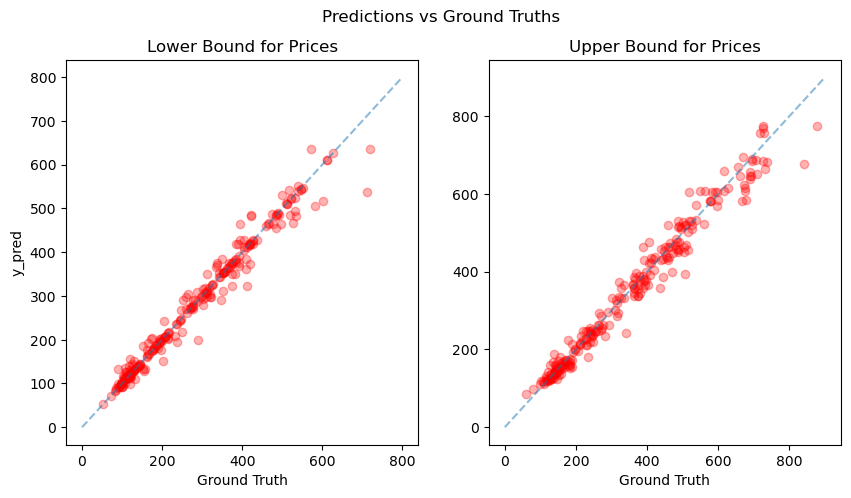

In [5]:
y_pred = pipeline.predict(X_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Predictions vs Ground Truths")

ax[0].set_title("Lower Bound for Prices")
ax[0].set_ylabel("y_pred")
ax[0].set_xlabel("Ground Truth")
ax[0].plot([0, 800], [0, 800], alpha=0.5, ls='dashed')
ax[0].scatter(y_train.iloc[:, 0], y_pred[:, 0], c="red", alpha=0.3)

ax[1].set_title("Upper Bound for Prices")
ax[1].set_xlabel("Ground Truth")
ax[1].plot([0, 900], [0, 900], alpha=0.5, ls='dashed')
ax[1].scatter(y_train.iloc[:, 1], y_pred[:, 1], c="red", alpha=0.3)
plt.show()

In [6]:
X_test = test.copy().drop(["lower_price_sgd", "upper_price_sgd"], axis=1)
y_test = test.copy()[["lower_price_sgd", "upper_price_sgd"]]
y_pred = pipeline.predict(X_test)

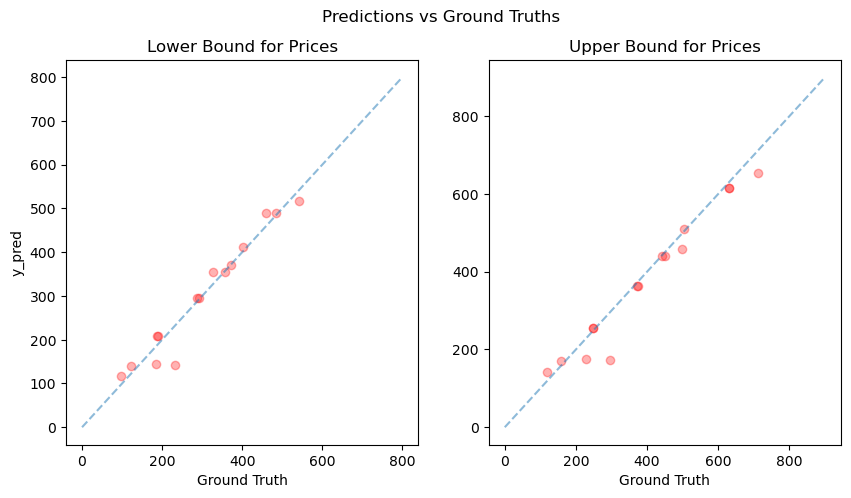

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Predictions vs Ground Truths")

ax[0].set_title("Lower Bound for Prices")
ax[0].set_ylabel("y_pred")
ax[0].set_xlabel("Ground Truth")
ax[0].plot([0, 800], [0, 800], alpha=0.5, ls='dashed')
ax[0].scatter(y_test.iloc[:, 0], y_pred[:, 0], c="red", alpha=0.3)

ax[1].set_title("Upper Bound for Prices")
ax[1].set_xlabel("Ground Truth")
ax[1].plot([0, 900], [0, 900], alpha=0.5, ls='dashed')
ax[1].scatter(y_test.iloc[:, 1], y_pred[:, 1], c="red", alpha=0.3)
plt.show()